In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [75]:
df = pd.read_csv("../data/processed/final_mine_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["zone_id", "timestamp"])

In [76]:
FEATURE_COLS = [
    "vibration_energy",
    "vibration_entropy",
    "acoustic_energy",
    "acoustic_hit_rate",
    "stress_index",
    "excavation_depth"
]

TARGET_COL = "risk_label"

X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

joblib.dump(scaler, "../models/lstm_scaler.pkl")
print("✅ Scaler saved to models/lstm_scaler.pkl")

✅ Scaler saved to models/lstm_scaler.pkl


In [78]:
def create_sequences(X, y, window_size=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

WINDOW_SIZE = 10
X_seq, y_seq = create_sequences(X_scaled, y, WINDOW_SIZE)

X_seq.shape, y_seq.shape

((890, 10, 6), (890,))

In [79]:
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=42
)

for train_idx, val_idx in sss.split(X_seq, y_seq):
    X_train, X_val = X_seq[train_idx], X_seq[val_idx]
    y_train, y_val = y_seq[train_idx], y_seq[val_idx]

In [80]:
print("Train distribution:", np.bincount(y_train))
print("Validation distribution:", np.bincount(y_val))

Train distribution: [232 480]
Validation distribution: [ 58 120]


In [81]:
classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, weights))
class_weight_dict

{0: 1.5344827586206897, 1: 0.7416666666666667}

In [82]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, X_seq.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 64)            18176     
                                                                 
 dropout_10 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30625 (119.63 KB)
Trainable params: 30625 (119.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [83]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/50
23/23 [==============================] - 1s 13ms/step - loss: 0.3728 - accuracy: 0.9438 - val_loss: 0.2355 - val_accuracy: 0.9775
Epoch 2/50
23/23 [==============================] - 0s 4ms/step - loss: 0.1200 - accuracy: 0.9888 - val_loss: 0.0522 - val_accuracy: 0.9944
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0489 - accuracy: 0.9888 - val_loss: 0.0298 - val_accuracy: 0.9944
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0385 - accuracy: 0.9888 - val_loss: 0.0262 - val_accuracy: 0.9944
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0373 - accuracy: 0.9888 - val_loss: 0.0230 - val_accuracy: 0.9944
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0328 - accuracy: 0.9902 - val_loss: 0.0204 - val_accuracy: 0.9944
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.0179 - val_accuracy: 0.9944
Epoch 8/50
23/23 [=

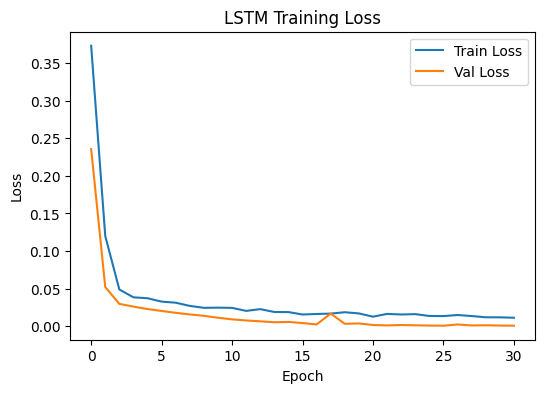

In [84]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [85]:
y_prob = model.predict(X_val)
y_pred = (y_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

6/6 [==============================] - 0s 1ms/step
Confusion Matrix:
[[ 58   0]
 [  0 120]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00       120

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [86]:
model.save("../models/lstm_risk_model")
print("✅ LSTM model saved successfully")

INFO:tensorflow:Assets written to: ../models/lstm_risk_model/assets


INFO:tensorflow:Assets written to: ../models/lstm_risk_model/assets


✅ LSTM model saved successfully


In [87]:
y_prob = model.predict(X_val)
y_pred = (y_prob > 0.5).astype(int)

comparison_df = pd.DataFrame({
    "Actual": y_val[:20],
    "Predicted": y_pred[:20].flatten(),
    "Probability": y_prob[:20].flatten()
})

comparison_df

6/6 [==============================] - 0s 1ms/step


,Actual,Predicted,Probability
0,1,1,0.993503
1,1,1,0.999802
2,0,0,0.002382
3,0,0,0.002050
4,1,1,0.999812
5,0,0,0.001855
6,0,0,0.001495
7,1,1,0.999800
8,1,1,0.999810
9,1,1,0.999813


In [88]:
print("Predicted class distribution:", np.bincount(y_pred.flatten()))
print("Actual class distribution:", np.bincount(y_val))

Predicted class distribution: [ 58 120]
Actual class distribution: [ 58 120]


In [ ]:
mismatch_df = pd.DataFrame({
    "Actual": y_val,
    "Predicted": y_pred.flatten(),
    "Probability": y_prob.flatten()
})

mismatch_df[mismatch_df["Actual"] != mismatch_df["Predicted"]].head(10)

In [ ]:
val_indices = df.iloc[WINDOW_SIZE:].iloc[y_val.index if hasattr(y_val, "index") else range(len(y_val))]

zone_check = pd.DataFrame({
    "zone_id": df.iloc[-len(y_val):]["zone_id"].values,
    "Actual": y_val,
    "Predicted": y_pred.flatten(),
    "Probability": y_prob.flatten()
})

zone_check.groupby("zone_id")[["Actual", "Predicted"]].mean()